In [168]:
# 必要なライブラリのインポート
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import json
import os
from pathlib import Path

# プロット設定
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📊 分析ライブラリ読み込み完了")
print("⚠️ 学習に影響を与えない軽量分析を実行します")


📊 分析ライブラリ読み込み完了
⚠️ 学習に影響を与えない軽量分析を実行します


In [169]:
# データベース接続と基本情報の取得
def get_optimization_status():
    """最適化状況を取得"""
    db_path = '../results/comprehensive_optimization/lstm_v2_comprehensive_optimization_w64_s16.db'
    
    if not os.path.exists(db_path):
        print(f"❌ データベースファイルが見つかりません: {db_path}")
        return None
    
    try:
        conn = sqlite3.connect(db_path)
        
        # 基本情報を取得
        basic_query = '''
        SELECT 
            COUNT(*) as total_trials,
            SUM(CASE WHEN state = 'COMPLETE' THEN 1 ELSE 0 END) as completed_trials,
            SUM(CASE WHEN state = 'RUNNING' THEN 1 ELSE 0 END) as running_trials,
            SUM(CASE WHEN state = 'FAIL' THEN 1 ELSE 0 END) as failed_trials
        FROM trials
        '''
        
        basic_info = pd.read_sql_query(basic_query, conn)
        
        # 試行詳細を取得
        trials_query = '''
        SELECT 
            trial_id,
            number,
            state,
            datetime_start,
            datetime_complete
        FROM trials
        ORDER BY number
        '''
        
        trials_df = pd.read_sql_query(trials_query, conn)
        
        # 試行値を取得
        values_query = '''
        SELECT 
            tv.trial_id,
            tv.value
        FROM trial_values tv
        JOIN trials t ON tv.trial_id = t.trial_id
        WHERE t.state = 'COMPLETE'
        ORDER BY t.number
        '''
        
        values_df = pd.read_sql_query(values_query, conn)
        
        conn.close()
        
        return {
            'basic_info': basic_info,
            'trials': trials_df,
            'values': values_df
        }
        
    except Exception as e:
        print(f"❌ エラー: {e}")
        return None

# 状況を取得
status = get_optimization_status()
if status:
    print("✅ 最適化状況の取得完了")
    print(f"📊 基本情報: {status['basic_info'].iloc[0].to_dict()}")
else:
    print("❌ 状況取得に失敗")


✅ 最適化状況の取得完了
📊 基本情報: {'total_trials': 50, 'completed_trials': 49, 'running_trials': 0, 'failed_trials': 1}


In [170]:
# 進捗状況の詳細分析
if status:
    basic = status['basic_info'].iloc[0]
    trials_df = status['trials']
    values_df = status['values']
    
    print("📈 " + "="*50)
    print("📈 現在の最適化進捗状況")
    print("📈 " + "="*50)
    print(f"🔄 総試行数: {basic['total_trials']}")
    print(f"✅ 完了済み: {basic['completed_trials']}")
    print(f"⏳ 実行中: {basic['running_trials']}")
    print(f"❌ 失敗: {basic['failed_trials']}")
    
    # 実行時間の分析
    completed_trials = trials_df[trials_df['state'] == 'COMPLETE'].copy()
    if not completed_trials.empty:
        completed_trials['duration'] = (
            pd.to_datetime(completed_trials['datetime_complete']) - 
            pd.to_datetime(completed_trials['datetime_start'])
        ).dt.total_seconds() / 60  # 分単位
        
        print(f"\n⏱️ 実行時間統計:")
        print(f"   平均: {completed_trials['duration'].mean():.1f}分")
        print(f"   最短: {completed_trials['duration'].min():.1f}分")
        print(f"   最長: {completed_trials['duration'].max():.1f}分")
        print(f"   合計: {completed_trials['duration'].sum():.1f}分")
    
    # 実行中試行の情報
    running_trials = trials_df[trials_df['state'] == 'RUNNING']
    if not running_trials.empty:
        for _, trial in running_trials.iterrows():
            start_time = pd.to_datetime(trial['datetime_start'])
            elapsed = (pd.Timestamp.now() - start_time).total_seconds() / 60
            print(f"\n🔄 実行中試行 {trial['number']}:")
            print(f"   開始: {start_time.strftime('%H:%M')}")
            print(f"   経過: {elapsed:.1f}分")
            
            # 推定完了時刻
            if not completed_trials.empty:
                avg_duration = completed_trials['duration'].mean()
                remaining = avg_duration - elapsed
                est_complete = datetime.now() + timedelta(minutes=remaining)
                print(f"   推定完了: {est_complete.strftime('%H:%M')} (あと{remaining:.1f}分)")
    
    print("\n" + "="*50)


📈 ==================================================
📈 現在の最適化進捗状況
📈 ==================================================
🔄 総試行数: 50
✅ 完了済み: 49
⏳ 実行中: 0
❌ 失敗: 1

⏱️ 実行時間統計:
   平均: 17.9分
   最短: 4.6分
   最長: 37.4分
   合計: 878.3分



🏆 性能統計:
   最高値: 0.8021
   最低値: 0.5979
   平均値: 0.7469
   標準偏差: 0.0446


/tmp/ipykernel_131884/4066157838.py:55: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_131884/4066157838.py:55: UserWarning: Glyph 36969 (\N{CJK UNIFIED IDEOGRAPH-9069}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_131884/4066157838.py:55: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_131884/4066157838.py:55: UserWarning: Glyph 23653 (\N{CJK UNIFIED IDEOGRAPH-5C65}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_131884/4066157838.py:55: UserWarning: Glyph 27508 (\N{CJK UNIFIED IDEOGRAPH-6B74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_131884/4066157838.py:55: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_131884/4066157838.py:55: UserWarning: Glyph 31309 (\N{CJK UNIFIED I

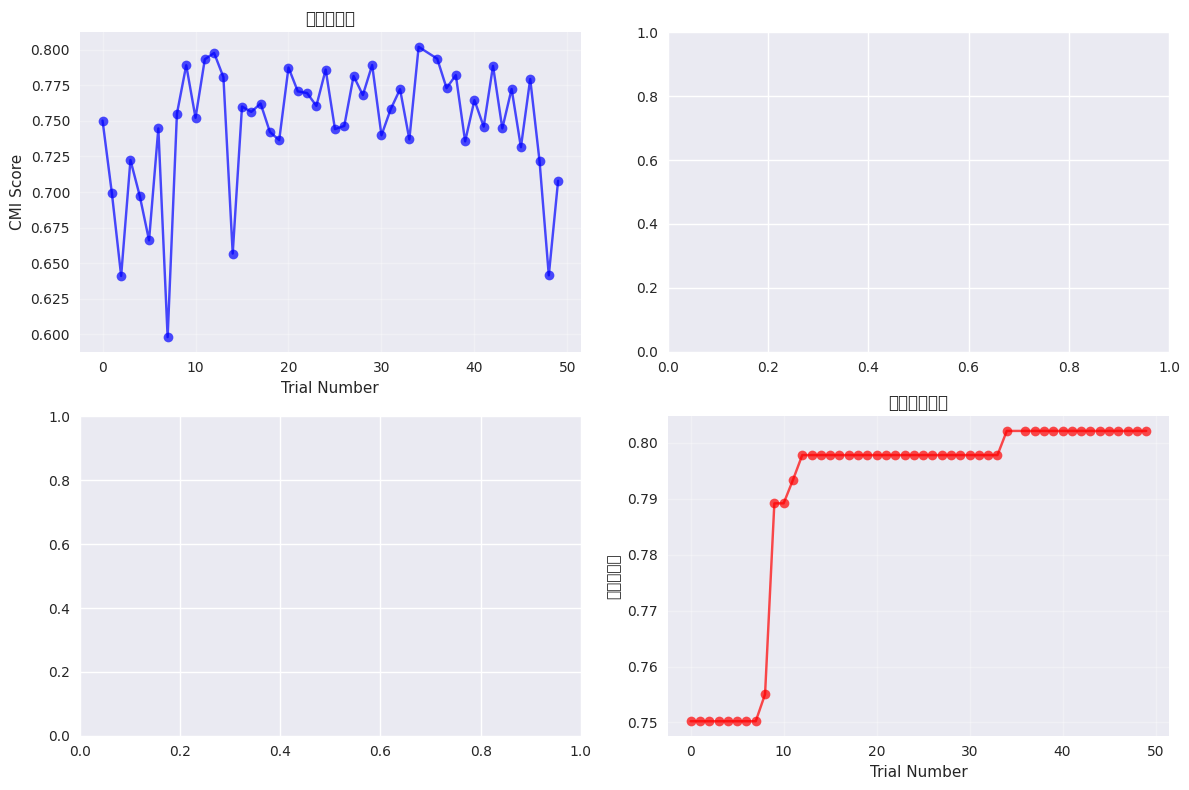


📊 可視化完了


In [171]:
# 性能分析と可視化
if status and not status['values'].empty:
    values_df = status['values']
    completed_trials = trials_df[trials_df['state'] == 'COMPLETE'].copy()
    
    # 値と試行番号をマージ
    performance_df = completed_trials.merge(values_df, on='trial_id')
    
    if not performance_df.empty:
        print(f"🏆 性能統計:")
        print(f"   最高値: {performance_df['value'].max():.4f}")
        print(f"   最低値: {performance_df['value'].min():.4f}")
        print(f"   平均値: {performance_df['value'].mean():.4f}")
        print(f"   標準偏差: {performance_df['value'].std():.4f}")
        
        # 軽量な可視化
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        # 1. 最適化履歴
        ax1 = axes[0, 0]
        ax1.plot(performance_df['number'], performance_df['value'], 'bo-', alpha=0.7)
        ax1.set_xlabel('Trial Number')
        ax1.set_ylabel('CMI Score')
        ax1.set_title('最適化履歴')
        ax1.grid(True, alpha=0.3)
        
        # 2. 実行時間の分布
        ax2 = axes[0, 1]
        if 'duration' in completed_trials.columns:
            ax2.hist(completed_trials['duration'], bins=5, alpha=0.7, color='green')
            ax2.set_xlabel('実行時間 (分)')
            ax2.set_ylabel('頻度')
            ax2.set_title('実行時間分布')
            ax2.grid(True, alpha=0.3)
        
        # 3. 性能と実行時間の関係
        ax3 = axes[1, 0]
        if 'duration' in completed_trials.columns:
            perf_time_df = completed_trials.merge(values_df, on='trial_id')
            ax3.scatter(perf_time_df['duration'], perf_time_df['value'], alpha=0.7)
            ax3.set_xlabel('実行時間 (分)')
            ax3.set_ylabel('CMI Score')
            ax3.set_title('性能 vs 実行時間')
            ax3.grid(True, alpha=0.3)
        
        # 4. 累積最高値
        ax4 = axes[1, 1]
        cumulative_best = performance_df['value'].cummax()
        ax4.plot(performance_df['number'], cumulative_best, 'ro-', alpha=0.7)
        ax4.set_xlabel('Trial Number')
        ax4.set_ylabel('累積最高値')
        ax4.set_title('累積最高性能')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\n📊 可視化完了")
    else:
        print("❌ 性能データがありません")
else:
    print("❌ 可視化用データがありません")


In [172]:
# 残り時間の推定
if status:
    completed_trials = trials_df[trials_df['state'] == 'COMPLETE'].copy()
    
    if not completed_trials.empty:
        # 平均実行時間の計算
        completed_trials['duration'] = (
            pd.to_datetime(completed_trials['datetime_complete']) - 
            pd.to_datetime(completed_trials['datetime_start'])
        ).dt.total_seconds() / 60
        
        avg_duration = completed_trials['duration'].mean()
        
        # 想定総試行数（設定から推定）
        total_expected_trials = 50  # w64_s16の想定試行数
        current_trials = len(trials_df)
        remaining_trials = max(0, total_expected_trials - current_trials)
        
        print("⏰ " + "="*50)
        print("⏰ 完了時刻推定")
        print("⏰ " + "="*50)
        print(f"📊 現在の進捗: {current_trials}/{total_expected_trials} ({current_trials/total_expected_trials*100:.1f}%)")
        print(f"⏳ 残り試行数: {remaining_trials}")
        print(f"⏱️ 平均実行時間: {avg_duration:.1f}分")
        
        # 実行中試行の残り時間
        running_trials = trials_df[trials_df['state'] == 'RUNNING']
        current_remaining = 0
        
        if not running_trials.empty:
            for _, trial in running_trials.iterrows():
                start_time = pd.to_datetime(trial['datetime_start'])
                elapsed = (pd.Timestamp.now() - start_time).total_seconds() / 60
                current_remaining = max(0, avg_duration - elapsed)
                print(f"🔄 現在実行中試行の残り時間: {current_remaining:.1f}分")
        
        # 総残り時間
        total_remaining = current_remaining + (remaining_trials * avg_duration)
        estimated_completion = datetime.now() + timedelta(minutes=total_remaining)
        
        print(f"\n🎯 推定完了時刻: {estimated_completion.strftime('%m/%d %H:%M')}")
        print(f"⏳ 総残り時間: {total_remaining:.1f}分 ({total_remaining/60:.1f}時間)")
        
        # w128_s32の推定
        if remaining_trials == 0:
            print(f"\n🚀 w64_s16設定完了後、w128_s32設定が開始されます")
            w128_completion = estimated_completion + timedelta(minutes=50*avg_duration)
            print(f"🎯 全体推定完了: {w128_completion.strftime('%m/%d %H:%M')}")
        
        print("\n" + "="*50)
    else:
        print("❌ 完了試行がないため推定できません")
else:
    print("❌ 状況データがありません")


⏰ ==================================================
⏰ 完了時刻推定
⏰ ==================================================
📊 現在の進捗: 50/50 (100.0%)
⏳ 残り試行数: 0
⏱️ 平均実行時間: 17.9分

🎯 推定完了時刻: 07/09 06:10
⏳ 総残り時間: 0.0分 (0.0時間)

🚀 w64_s16設定完了後、w128_s32設定が開始されます
🎯 全体推定完了: 07/09 21:06



In [173]:
# 簡易レポート生成
print("📋 " + "="*50)
print("📋 学習途中レポート")
print("📋 " + "="*50)
print(f"📅 実行日時: {datetime.now().strftime('%Y/%m/%d %H:%M:%S')}")
print(f"🔄 実行状況: 学習途中での分析")
print(f"⚠️ 注意: 学習プロセスに影響を与えない軽量分析です")
print("\n💡 推奨事項:")
print("   - 学習完了後により詳細な分析を実行")
print("   - 現在の傾向を参考に次の実験を計画")
print("   - システムリソースの監視を継続")
print("\n" + "="*50)
print("✅ 学習途中分析完了")


📋 ==================================================
📋 学習途中レポート
📋 ==================================================
📅 実行日時: 2025/07/09 06:10:01
🔄 実行状況: 学習途中での分析
⚠️ 注意: 学習プロセスに影響を与えない軽量分析です

💡 推奨事項:
   - 学習完了後により詳細な分析を実行
   - 現在の傾向を参考に次の実験を計画
   - システムリソースの監視を継続

✅ 学習途中分析完了


In [174]:
#!/usr/bin/env python3
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# プロジェクトルートを追加
sys.path.append('../src')

import optuna
from cmi_evaluation import calculate_cmi_score, print_gesture_info

print("📚 ライブラリ読み込み完了")
print(f"📅 分析開始時刻: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


📚 ライブラリ読み込み完了
📅 分析開始時刻: 2025-07-09 06:10:01


In [175]:
# 


In [176]:
# 📊 包括的サマリーの読み込み
summary_path = results_path / "comprehensive_optimization_summary.json"

if summary_path.exists():
    with open(summary_path, 'r', encoding='utf-8') as f:
        comprehensive_summary = json.load(f)
    
    print("📊 包括的サマリー読み込み完了")
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    
    # 実験情報
    exp_info = comprehensive_summary['experiment_info']
    print(f"🔬 実験情報:")
    print(f"   実験名: {exp_info['study_base_name']}")
    print(f"   ウィンドウ設定: {exp_info['window_configs']}")
    print(f"   Fusion方式: {exp_info['fusion_types']}")
    print(f"   各設定の試行数: {exp_info['trials_per_config']}")
    print(f"   実行日時: {exp_info['timestamp']}")
    
    # 最良結果
    best_overall = comprehensive_summary['best_overall']
    print(f"\n🏆 最良結果:")
    print(f"   ウィンドウ設定: {best_overall['window_config']}")
    print(f"   CMIスコア: {best_overall['cmi_score']:.4f}")
    
    # 最終評価
    if 'final_evaluation' in comprehensive_summary:
        final_eval = comprehensive_summary['final_evaluation']
        print(f"\n🎯 最終評価:")
        print(f"   CMI Score: {final_eval['cmi_score']:.4f}")
        print(f"   Binary F1: {final_eval['binary_f1']:.4f}")
        print(f"   Macro F1: {final_eval['macro_f1']:.4f}")
        print(f"   Test Accuracy: {final_eval['test_accuracy']:.4f}")
    
else:
    print("❌ 包括的サマリーファイルが見つかりません")
    comprehensive_summary = None


📊 包括的サマリー読み込み完了
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔬 実験情報:
   実験名: lstm_v2_comprehensive_optimization
   ウィンドウ設定: ['w64_s16']
   Fusion方式: ['concatenate', 'attention', 'gated']
   各設定の試行数: 50
   実行日時: 2025-07-09T00:42:15.433693

🏆 最良結果:
   ウィンドウ設定: w64_s16
   CMIスコア: 0.8021

🎯 最終評価:
   CMI Score: 0.7929
   Binary F1: 0.9491
   Macro F1: 0.6366
   Test Accuracy: 0.6062


In [177]:
# 🗄️ Optuna Studyの復元
print("🗄️ Optuna Study復元")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")

studies = {}
window_configs = exp_info['window_configs'] if comprehensive_summary else ['w64_s16', 'w128_s32']
study_base_name = exp_info['study_base_name'] if comprehensive_summary else 'lstm_v2_comprehensive_optimization'

for window_config in window_configs:
    study_name = f"{study_base_name}_{window_config}"
    storage_url = f"sqlite:///{results_path}/{study_name}.db"
    
    try:
        # Studyの読み込み
        study = optuna.load_study(
            study_name=study_name,
            storage=storage_url
        )
        
        studies[window_config] = study
        
        # 統計情報
        completed_trials = [t for t in study.trials if t.value is not None]
        failed_trials = [t for t in study.trials if t.value is None]
        
        print(f"✅ {window_config}:")
        print(f"   総試行数: {len(study.trials)}")
        print(f"   成功試行: {len(completed_trials)}")
        print(f"   失敗試行: {len(failed_trials)}")
        
        if study.best_trial:
            print(f"   最良CMIスコア: {study.best_value:.4f}")
            print(f"   最良Fusion方式: {study.best_trial.user_attrs.get('fusion_type', 'N/A')}")
        
    except Exception as e:
        print(f"❌ {window_config}: Studyの読み込みに失敗 - {str(e)}")

print(f"\n✅ Study復元完了: {len(studies)}個のStudy")


🗄️ Optuna Study復元
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


✅ w64_s16:
   総試行数: 50
   成功試行: 49
   失敗試行: 1
   最良CMIスコア: 0.8021
   最良Fusion方式: attention

✅ Study復元完了: 1個のStudy


In [178]:
# 📈 詳細統計分析
if studies:
    print("📈 詳細統計分析")
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
    
    # 全体統計
    all_trials = []
    for window_config, study in studies.items():
        for trial in study.trials:
            if trial.value is not None:
                trial_data = {
                    'window_config': window_config,
                    'trial_number': trial.number,
                    'cmi_score': trial.value,
                    'fusion_type': trial.user_attrs.get('fusion_type', 'unknown'),
                    'binary_f1': trial.user_attrs.get('binary_f1', 0),
                    'macro_f1': trial.user_attrs.get('macro_f1', 0),
                    'test_accuracy': trial.user_attrs.get('test_accuracy', 0)
                }
                # パラメータも追加
                trial_data.update(trial.params)
                all_trials.append(trial_data)
    
    # DataFrameに変換
    df_trials = pd.DataFrame(all_trials)
    
    print(f"📊 統計サマリー:")
    print(f"   総試行数: {len(df_trials)}")
    print(f"   平均CMIスコア: {df_trials['cmi_score'].mean():.4f}")
    print(f"   最高CMIスコア: {df_trials['cmi_score'].max():.4f}")
    print(f"   標準偏差: {df_trials['cmi_score'].std():.4f}")
    
    # ウィンドウサイズ別統計
    print(f"\n📏 ウィンドウサイズ別統計:")
    for window_config in window_configs:
        subset = df_trials[df_trials['window_config'] == window_config]
        if not subset.empty:
            print(f"   {window_config}:")
            print(f"     試行数: {len(subset)}")
            print(f"     平均: {subset['cmi_score'].mean():.4f}")
            print(f"     最高: {subset['cmi_score'].max():.4f}")
            print(f"     標準偏差: {subset['cmi_score'].std():.4f}")
    
    # Fusion方式別統計
    print(f"\n🔗 Fusion方式別統計:")
    fusion_stats = df_trials.groupby('fusion_type')['cmi_score'].agg(['count', 'mean', 'max', 'std'])
    for fusion_type, stats in fusion_stats.iterrows():
        print(f"   {fusion_type}:")
        print(f"     試行数: {stats['count']}")
        print(f"     平均: {stats['mean']:.4f}")
        print(f"     最高: {stats['max']:.4f}")
        print(f"     標準偏差: {stats['std']:.4f}")
else:
    print("❌ 統計分析用のStudyデータがありません")


📈 詳細統計分析
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 統計サマリー:
   総試行数: 49
   平均CMIスコア: 0.7469
   最高CMIスコア: 0.8021
   標準偏差: 0.0446

📏 ウィンドウサイズ別統計:
   w64_s16:
     試行数: 49
     平均: 0.7469
     最高: 0.8021
     標準偏差: 0.0446

🔗 Fusion方式別統計:
   attention:
     試行数: 22.0
     平均: 0.7472
     最高: 0.8021
     標準偏差: 0.0486
   concatenate:
     試行数: 7.0
     平均: 0.7299
     最高: 0.7682
     標準偏差: 0.0350
   gated:
     試行数: 20.0
     平均: 0.7526
     最高: 0.7978
     標準偏差: 0.0433


In [179]:
# 🎉 分析完了サマリー
print("\n" + "="*60)
print("🎉 学習結果分析完了")
print("="*60)

if comprehensive_summary:
    print(f"📈 復元された実験: {comprehensive_summary['experiment_info']['study_base_name']}")
    print(f"📅 実行日時: {comprehensive_summary['experiment_info']['timestamp']}")

if studies:
    total_trials = sum(len(study.trials) for study in studies.values())
    print(f"🗄️ 復元されたStudy: {len(studies)}個")
    print(f"📊 総試行数: {total_trials}")

if 'df_trials' in locals():
    print(f"🏆 最高CMIスコア: {df_trials['cmi_score'].max():.4f}")
    best_trial = df_trials.loc[df_trials['cmi_score'].idxmax()]
    print(f"🔧 最良設定: {best_trial['window_config']}, {best_trial['fusion_type']}")

print(f"\n📁 利用可能な結果:")
print(f"   📊 包括的可視化: {results_path}/comprehensive_optimization_results.png")
print(f"   📄 詳細データ: {results_path}/comprehensive_optimization_summary.json")
print(f"   🤖 本番モデル: {results_path}/production_model/")

print(f"\n💡 次のアクション:")
print(f"   1. 包括的可視化グラフの確認")
print(f"   2. 本番モデルでのテスト実行")
print(f"   3. さらなる最適化の検討")

print(f"\n✨ カーネル再起動後も同じ分析を再実行可能！")
print("="*60)



🎉 学習結果分析完了
📈 復元された実験: lstm_v2_comprehensive_optimization
📅 実行日時: 2025-07-09T00:42:15.433693
🗄️ 復元されたStudy: 1個
📊 総試行数: 50
🏆 最高CMIスコア: 0.8021
🔧 最良設定: w64_s16, attention

📁 利用可能な結果:
   📊 包括的可視化: ../results/comprehensive_optimization/comprehensive_optimization_results.png
   📄 詳細データ: ../results/comprehensive_optimization/comprehensive_optimization_summary.json
   🤖 本番モデル: ../results/comprehensive_optimization/production_model/

💡 次のアクション:
   1. 包括的可視化グラフの確認
   2. 本番モデルでのテスト実行
   3. さらなる最適化の検討

✨ カーネル再起動後も同じ分析を再実行可能！
